In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../qbiome'))

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
plt.style.use('ggplot')

from data_formatter import DataFormatter
from quantizer import Quantizer
from qnet_orchestrator import QnetOrchestrator
from mask_checker import MaskChecker

In [2]:
dirname = '../../infbiome_/data2/'
data = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv'
meta = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv'

In [3]:
formatter = DataFormatter()
quantizer = Quantizer()
qnet_orchestrator = QnetOrchestrator(quantizer)
mask_checker = MaskChecker(qnet_orchestrator)

In [4]:
data = formatter.load_data(data, meta)
quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)

There are 29 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


In [5]:
len(features)

622

In [6]:
qnet_orchestrator.load_qnet('biome_net.joblib')

In [7]:
# takes 2 minutes to run
predicted = mask_checker.mask_and_predict(label_matrix, mask_percent=20)

In [8]:
data.head()

,sample_id,subject_id,variable,week,value
7,MBSMPL0020-6-10,1,Actinobacteriota,27,0.366650
8,MBSMPL0020-6-10,1,Bacteroidota,27,0.507248
9,MBSMPL0020-6-10,1,Campilobacterota,27,0.002032
10,MBSMPL0020-6-10,1,Desulfobacterota,27,0.005058
11,MBSMPL0020-6-10,1,Firmicutes,27,0.057767


In [9]:
predicted.head()

,subject_id,variable,week,value
0,1,Acidobacteriota,1,0.003747
1,10,Acidobacteriota,1,0.003716
2,11,Acidobacteriota,1,0.004189
3,12,Acidobacteriota,1,0.003652
4,14,Acidobacteriota,1,0.003810


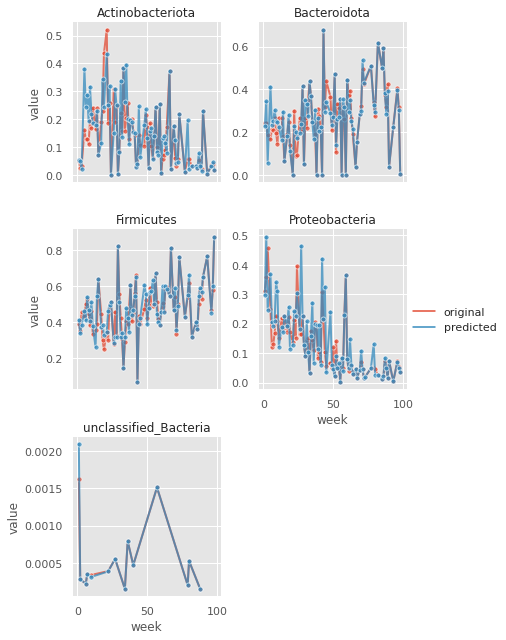

In [10]:
BIOMES = ['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'unclassified_Bacteria']

concat = pd.concat([
    data.assign(source='original'), 
    predicted.assign(source='predicted')
])
concat = concat[concat.variable.isin(BIOMES)]

g = sns.FacetGrid(concat, col='variable', col_wrap=2, sharey=False, margin_titles=True)
g.map_dataframe(sns.lineplot, 'week', 'value', hue='source', ci=None, marker='o',
                    linewidth=2, alpha=0.75, markersize=5)
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.add_legend()

It appears that the prediction passes our eyeball sanity check.